# **Dessert Flavor Combinations**
The goal here is predict what flavor combinations make for a good dessert. E.g. history tells us apple, cinammon, and nutmeg pair well because a large number of recipies use these flavors and these recipies are generally well rated. Here, I attempt to do this with a data set scrapped from epicurious.com. Basically, the features are a list of flavors present in the recipie and the target is the rating (0 to 4 stars)

In [1]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk as nltk
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline, make_union
from sklearn.decomposition import SparsePCA, TruncatedSVD, PCA, DictionaryLearning, NMF
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1) Load data

In [2]:
dataset = pd.read_csv('recipes.csv')

## 2) Clean Data

In [3]:
#Remove entires that dont have strings for the flavors
dataset = dataset[dataset['flavors'].apply(lambda x: isinstance(x, str))]

#tokenize the flavor string 
temp = dataset['flavors'].apply(lambda x: np.unique(nltk.word_tokenize(x)))

#Calc number of flavors
dataset.loc[:,'num_flavors'] = temp.apply(lambda x: x.shape[0])

#Remove entries with only 1 flavor
dataset = dataset[dataset['num_flavors'] > 1]

#convert rating to float
dataset.loc[:,'rating'] = dataset['rating'].apply(lambda x: float(x))

dataset.loc[:,'flavors_clean'] = temp.apply(lambda x: "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in x]).strip())

#So, one thing I have yet to do is account for recipes that have no reviews...
#I need to re-scrape the data set to get that info, for now lets just remove
#recipies with a rating of 0
dataset = dataset[dataset['rating'] != 0]

## 3) Preprocess

In [4]:
#Get features and targets
features = dataset['flavors_clean'].values
targets = dataset['rating'].values

#First lets try the hold-out method for validation
train, test, y_train, y_test = train_test_split(features, targets, test_size=0.40, random_state=0)
test, valid, y_test, y_valid = train_test_split(test, y_test, test_size=0.40, random_state=0)

print(train.shape)
print(test.shape)
print(valid.shape)

(3474,)
(1390,)
(927,)


In [5]:
#Set up a pipeline:
#   1) Use TF-IDF to generate features
#   2) maybe other things later????
vectorizer = make_pipeline(
    TfidfVectorizer(sublinear_tf=True)
)

x_train = vectorizer.fit_transform(train)
x_test = vectorizer.transform(test)
x_valid = vectorizer.transform(valid)

## 4) Check out our data

<IPython.core.display.Javascript object>


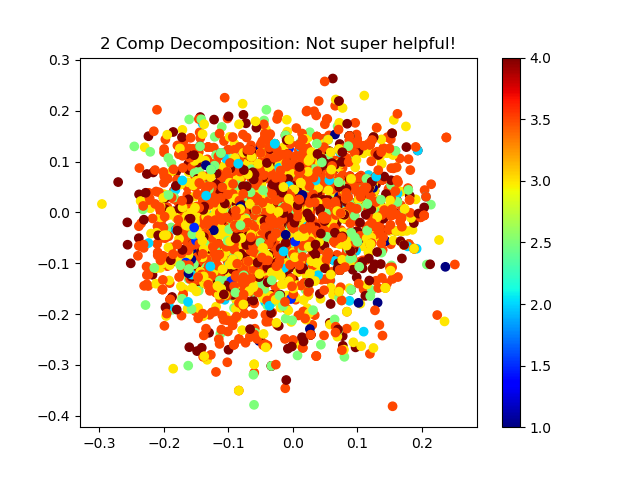

<IPython.core.display.Javascript object>


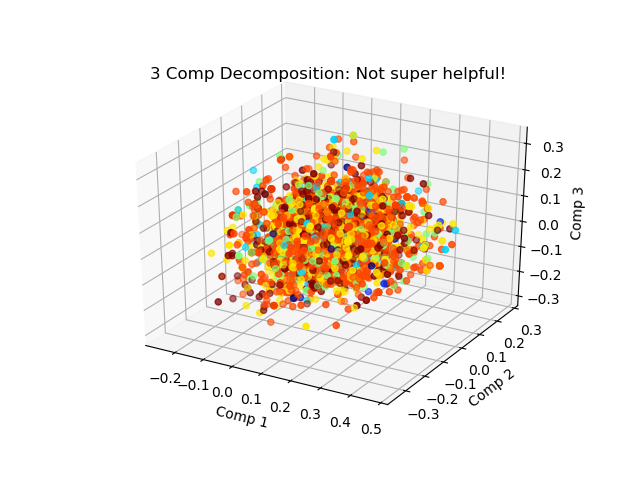

In [6]:
#Start with dimensional reduction to view it in 2D
fig = plt.figure()
dim_red = DictionaryLearning(2)
reduced_data = dim_red.fit_transform(x_train.toarray())
plt.scatter(reduced_data[:,0],reduced_data[:,1],c=y_train,cmap='jet')
plt.colorbar()
plt.title('2 Comp Decomposition: Not super helpful!')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dim_red = DictionaryLearning(3)
reduced_data = dim_red.fit_transform(x_train.toarray())
ax.scatter(reduced_data[:,0],reduced_data[:,1],reduced_data[:,2],c=y_train,cmap='jet')
plt.title('3 Comp Decomposition: Not super helpful!')
ax.set_xlabel('Comp 1')
ax.set_ylabel('Comp 2')
ax.set_zlabel('Comp 3')
plt.show()

## 5) Model

In [7]:
#Take a few stabs in the dark!

model = SVR(
    C=50,
    kernel='linear',
    gamma=1.4,
    coef0=1,
    cache_size=100,
)

#model = RandomForestRegressor(
#    n_estimators = 4
#)

#model = GradientBoostingRegressor(
#)

## 6) Train

In [8]:
model.fit(x_train,y_train)

SVR(C=50, cache_size=100, coef0=1, degree=3, epsilon=0.1, gamma=1.4,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## 7) Validate

In [9]:
y_pred_valid = model.predict(x_valid)
print('Mean Squared Error: ',mean_squared_error(y_valid, y_pred_valid))
print('MAE: ',mean_absolute_error(y_valid, y_pred_valid))

Mean Squared Error:  0.30592509133831564
MAE:  0.39971152395087733


## 8) Test

In [10]:
y_pred_test = model.predict(x_test)
print('Mean Squared Error: ',mean_squared_error(y_test, y_pred_test))
print('MAE: ',mean_absolute_error(y_test, y_pred_test))

Mean Squared Error:  0.32245854998160056
MAE:  0.3979663363687824


## So it appears we have an error of around 0.4 a star... Not great...